# Heart Attack Risk Classification

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv("heart.csv")
df.info()

# patients are classified as either low risk or high risk.
categories = ['Low risk', 'High risk']

# a beta score (weighted F1 score) with beta = 1.2 is used to measure the strength of the models
# weights recall 1.2 times as much as precision
from sklearn.metrics import fbeta_score, make_scorer
heart_score = make_scorer(fbeta_score, beta = 1.2)
print(df.groupby('output').size())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   thalachh  303 non-null    int64  
 4   exng      303 non-null    int64  
 5   oldpeak   303 non-null    float64
 6   slp       303 non-null    int64  
 7   caa       303 non-null    int64  
 8   output    303 non-null    int64  
dtypes: float64(1), int64(8)
memory usage: 21.4 KB
output
0    138
1    165
dtype: int64


# Naive Bayes

## Continuous features

In [2]:
from sklearn.naive_bayes import GaussianNB

# sets of features
featureSets = [[0, 3, 5], [0], [3], [5], [0, 3], [0, 5], [3, 5]]

# run through sets of features
for features in featureSets:
    # set up the training set
    X = df.iloc[:, features].values
    y = pd.factorize(df['output'].values)[0]
    
    print('Features:', features, end = '\t')
    model = GaussianNB()
    model.fit(X, y)
    y_pred = model.predict(X)
    print("F-beta score:", fbeta_score(y, y_pred, beta = 1.2))

Features: [0, 3, 5]	F-beta score: 0.6681354651894749
Features: [0]	F-beta score: 0.6411718662641172
Features: [3]	F-beta score: 0.5881092662024637
Features: [5]	F-beta score: 0.5493211415904683
Features: [0, 3]	F-beta score: 0.6163172518312705
Features: [0, 5]	F-beta score: 0.5791139240506329
Features: [3, 5]	F-beta score: 0.6480953614926147


### Confusion matrix

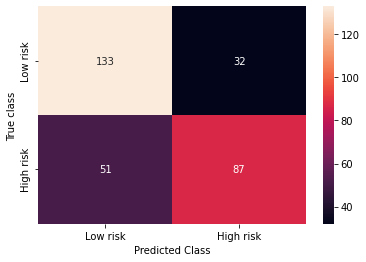

In [3]:
from sklearn.metrics import confusion_matrix

# Generate the training set
features = [0, 3, 5]
X = df.iloc[:,features].values
y = pd.factorize(df['output'].values)[0]

# Train the model and predict the class for each training set
model = GaussianNB()
model.fit(X, y)
y_pred = model.predict(X)

# Calculate the confusion matrix
confusion = confusion_matrix(y, y_pred)

# Plot the confusion matrix as a heat map
def visualize_confusion_matrix(confusion):
    sns.heatmap(confusion, annot = True, xticklabels = categories, yticklabels = categories, fmt = 'g')
    plt.xlabel("Predicted Class")
    plt.ylabel("True class")
    plt.show()
    
visualize_confusion_matrix(confusion)

### Classification regions

In [4]:
from sklearn.decomposition import PCA as sklearnPCA

def show_classification_regions():
    # Plot the decision boundaries
    # If the number of features is more than 2, reduce dimensionality to 2
    if len(features) > 2:
        pca = sklearnPCA(n_components = 2)
        pca.fit(X)
        X_pca = pca.transform(X)
    else: 
        X_pca = X

    # Determine the limits of the space
    xMin, xMax = X_pca[:, 0].min() - 0.1, X_pca[:, 0].max() + 0.1
    yMin, yMax = X_pca[:, 1].min() - 0.1, X_pca[:, 1].max() + 0.1
    # Generate the 2D mesh for the decision surface
    resolution = 0.02
    xx, yy = np.meshgrid(np.arange(xMin, xMax, resolution), np.arange(yMin, yMax, resolution))
    meshPts = np.array([xx.ravel(), yy.ravel()]).T
    # Transform the mesh points back to the original space
    if len(features) > 2:
        meshPts = pca.inverse_transform(meshPts)
    # Predict the classification for the mesh points
    predictedMesh = model.predict(meshPts)
    predictedMesh = predictedMesh.reshape(xx.shape)
    # Set up the figure
    fig, ax =  plt.subplots(1,1)
    # Plot the regions and decision boundaries using the mesh
    plt.contourf(xx, yy, predictedMesh, alpha = 0.2, cmap = 'Set1')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    # Plot each category
    sns.scatterplot(x = X_pca[:,0], y = X_pca[:,1], hue = y, palette = 'Set1')
    # Add axis labels 
    if len(features) > 2:
        plt.xlabel('PCA feature 1')
        plt.ylabel('PCA feature 2')
    else:
        plt.xlabel(df.columns[features[0]])
        plt.ylabel(df.columns[features[1]])
    # Customize legend labels
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles, categories)
    plt.show()

### Learning curves

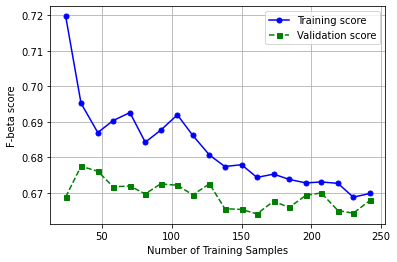

In [5]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedShuffleSplit

# Generate the training set
features = [0, 3, 5]
X = df.iloc[:,features].values
y = pd.factorize(df['output'].values)[0]

# Create the model
model = GaussianNB()

def plot_learning_curves(start, splits, testSize):
    # Test different training sizes
    train_sizes = np.linspace(start, 1.0, 20)

    # Create the cross validation objects
    # Specify a large number of splits to average different trials and obtain a smoother curve
    cv = StratifiedShuffleSplit(n_splits=splits, test_size = testSize, random_state=1)

    # Generate the learning curves averages
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, train_sizes = train_sizes, cv = cv, scoring = heart_score)
    train_mean = np.mean(train_scores, axis = 1)
    test_mean = np.mean(test_scores, axis = 1)

    # Plot the learning curves
    plt.plot(train_sizes, train_mean, color = 'blue', marker = 'o', markersize = 5, label = 'Training score')
    plt.plot(train_sizes, test_mean, color = 'green', marker = 's', linestyle = '--', markersize = 5, label = 'Validation score')
    plt.grid()
    plt.xlabel('Number of Training Samples')
    plt.ylabel('F-beta score')
    plt.legend()
    plt.show()
plot_learning_curves(0.1, 50, 0.2)

### Cross validation score

In [6]:
from sklearn.model_selection import cross_val_score

# Generate the training set
features = [0, 3, 5]
X = df.iloc[:,features].values
y = pd.factorize(df['output'].values)[0]

# Create the model
model = GaussianNB()

# Stratified cross validation is used, cv specifies the number of folds
cv_scores = cross_val_score(model, X, y, cv = 5, scoring = heart_score)
print(cv_scores)
print(np.mean(cv_scores))
print(np.std(cv_scores))

[0.68865122 0.68283582 0.62757202 0.68753914 0.65966921]
0.6692534804990228
0.023342322285434168


### Cross validation classification

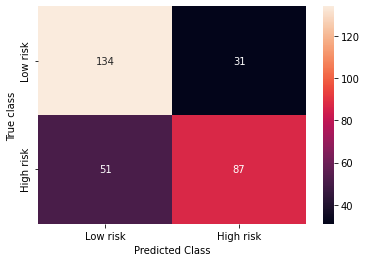

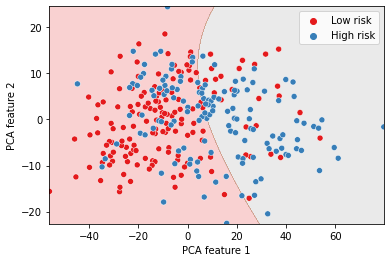

In [7]:
from sklearn.model_selection import cross_val_predict

y_pred = cross_val_predict(model, X, y, cv = 5)
confusion = confusion_matrix(y, y_pred)
visualize_confusion_matrix(confusion)

model.fit(X, y)
show_classification_regions()

## Binary/Categorical features

In [8]:
from sklearn.naive_bayes import CategoricalNB

print(df.groupby('caa').size())

# sets of features
featureSets = [[1, 2, 4, 6, 7], [1, 2, 4, 6], [1, 2, 4, 7], [1, 2, 6, 7], [1, 4, 6, 7], [2, 4, 6 ,7]]

# there were not enough samples with caa = 4
modifiedDF = df[df['caa'] != 4]
    
# run through sets of features
for features in featureSets:
    # set up the training set
    X = modifiedDF.iloc[:, features].values
    y = pd.factorize(modifiedDF['output'].values)[0]
    
    print('Features:', features, end = '\t')
    model = CategoricalNB()
    model.fit(X, y)
    y_pred = model.predict(X)
    print("F-beta score:", fbeta_score(y, y_pred, beta = 1.2))

caa
0    175
1     65
2     38
3     20
4      5
dtype: int64
Features: [1, 2, 4, 6, 7]	F-beta score: 0.8272923667786846
Features: [1, 2, 4, 6]	F-beta score: 0.7260085191681284
Features: [1, 2, 4, 7]	F-beta score: 0.7900579745898606
Features: [1, 2, 6, 7]	F-beta score: 0.7891635711540924
Features: [1, 4, 6, 7]	F-beta score: 0.7925018559762433
Features: [2, 4, 6, 7]	F-beta score: 0.7833653384541527


### Confusion matrix

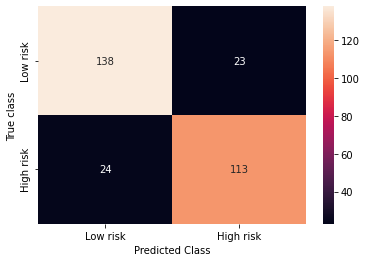

In [9]:
# Generate the training set
features = [1, 2, 4, 6, 7]
X = modifiedDF.iloc[:,features].values
y = pd.factorize(modifiedDF['output'].values)[0]

# Train the model and predict the class for each training set
model = CategoricalNB()
model.fit(X, y)
y_pred = model.predict(X)

# Calculate the confusion matrix
confusion = confusion_matrix(y, y_pred)

visualize_confusion_matrix(confusion)

### Learning curves

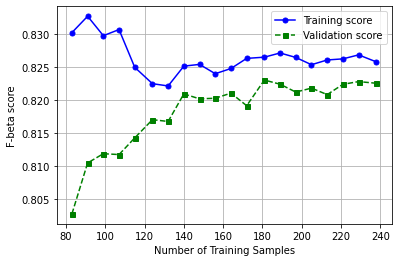

In [10]:
# Generate the training set
features = [1, 2, 4, 6, 7]
X = modifiedDF.iloc[:,features].values
y = pd.factorize(modifiedDF['output'].values)[0]

# Create the model
model = CategoricalNB()

plot_learning_curves(0.35, 50, 0.2)

### Cross validation score

In [11]:
# Generate the training set
features = [1, 2, 4, 6, 7]
X = modifiedDF.iloc[:,features].values
y = pd.factorize(modifiedDF['output'].values)[0]

# Create the model
model = CategoricalNB()

# Stratified cross validation is used, cv specifies the number of folds
cv_scores = cross_val_score(model, X, y, cv = 5, scoring = heart_score)
print(cv_scores)
print(np.mean(cv_scores))
print(np.std(cv_scores))

[0.74919198 0.87997692 0.86524823 0.85185185 0.76149803]
0.8215534021671675
0.05492424540933004


### Cross validation classification

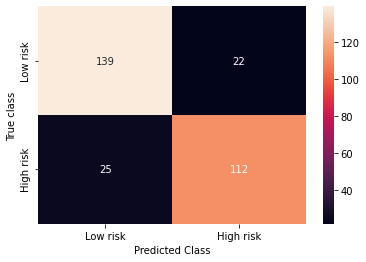

In [12]:
y_pred = cross_val_predict(model, X, y, cv = 5)
confusion = confusion_matrix(y, y_pred)
visualize_confusion_matrix(confusion)

# Decision Trees

## Continuous features

In [51]:
from sklearn.tree import DecisionTreeClassifier

# Define all possible sets of features
featureSets = [[0, 3, 5], [0, 3], [0, 5], [3, 5]]

# Run through all sets of features
for features in featureSets:
    # Assemble the training set 
    X = df.iloc[:, features].values
    y = pd.factorize(df['output'].values)[0]
    # Training and training accuracy
    print("Features:", features, end = "\t")
    model = DecisionTreeClassifier(max_depth = 3, random_state = 1)
    model.fit(X, y)
    y_pred = model.predict(X)
    print("F-beta score:", fbeta_score(y, y_pred, beta = 1.2))

Features: [0, 3, 5]	F-beta score: 0.6966277038828428
Features: [0, 3]	F-beta score: 0.6749968917070744
Features: [0, 5]	F-beta score: 0.5305938812237552
Features: [3, 5]	F-beta score: 0.6919791805685307


### Confusion matrix

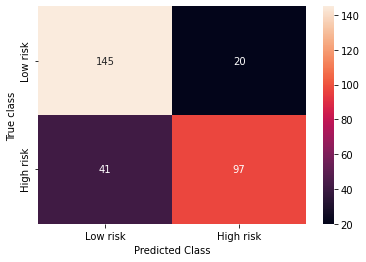

In [48]:
# Generate the training set
features = [0, 3, 5]
X = df.iloc[:,features].values
y = pd.factorize(df['output'].values)[0]

# Train the model and predict the class for each training set
model = DecisionTreeClassifier(criterion = 'entropy', max_depth = 6, min_samples_split = 20, random_state = 1)
model.fit(X, y)
y_pred = model.predict(X)

# Calculate the confusion matrix
confusion = confusion_matrix(y, y_pred)

visualize_confusion_matrix(confusion)

### Classification regions

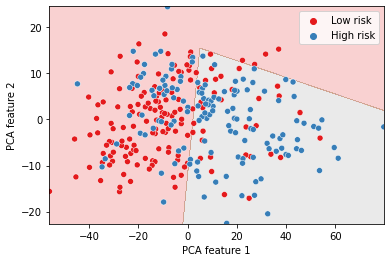

In [15]:
show_classification_regions()

### Learning curves

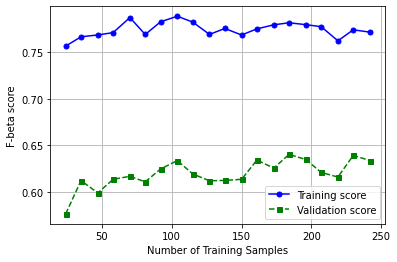

In [47]:
# Generate the training set
features = [0, 3, 5]
X = df.iloc[:,features].values
y = pd.factorize(df['output'].values)[0]

# Create the model
model = DecisionTreeClassifier(criterion = 'entropy', max_depth = 6, min_samples_split = 20, random_state = 1)

plot_learning_curves(0.1, 50, 0.2)

### Validation curves

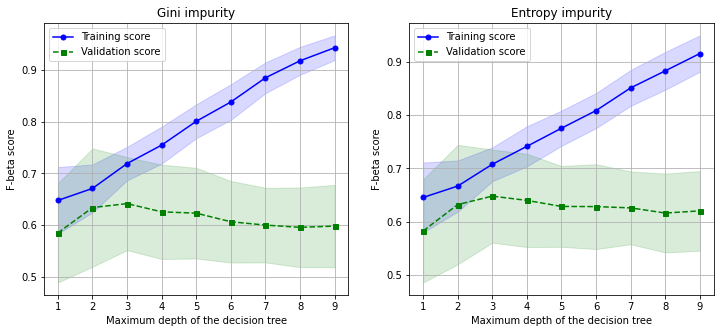

In [17]:
from sklearn.model_selection import validation_curve

# Generate the training set
features = [0, 3, 5]
X = df.iloc[:,features].values
y = pd.factorize(df['output'].values)[0]

# Explore a range values for the maximum depth
param_range = range(1,10)
    
def generate_and_plot_validation_curves_decisiontree(model, ax): 
    cv = StratifiedShuffleSplit(n_splits=50, test_size = 0.2, random_state=1)
    # Generate the validation curves averages and standard deviations 
    train_scores, test_scores = validation_curve(model, X, y, param_name = 'max_depth', param_range = param_range, cv = cv, scoring = heart_score)
    train_mean = np.mean(train_scores, axis = 1)
    train_std = np.std(train_scores, axis = 1)
    test_mean = np.mean(test_scores, axis = 1)
    test_std = np.std(test_scores, axis = 1)

    # Plot the validation curves in the figure axis
    ax.plot(param_range, train_mean, color = 'blue', marker = 'o', markersize = 5, label = 'Training score')
    ax.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha = 0.15, color = 'blue')
    ax.plot(param_range, test_mean, color = 'green', marker = 's', linestyle = '--', markersize = 5, label = 'Validation score')
    ax.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha = 0.15, color = 'green')
    ax.grid()
    ax.set_xlabel('Maximum depth of the decision tree')
    ax.set_ylabel('F-beta score')
    ax.legend()
    
# Generate the validation curves for a model using the gini impurity measure
fig, ax = plt.subplots(1, 2, figsize = (12,5))
model = DecisionTreeClassifier(criterion = 'gini', random_state = 1)
generate_and_plot_validation_curves_decisiontree(model, ax[0])
ax[0].set_title('Gini impurity')

# Generate the validation curves for a model using the entropy impurity measure
model = DecisionTreeClassifier(criterion = 'entropy', random_state = 1)
generate_and_plot_validation_curves_decisiontree(model, ax[1])
ax[1].set_title('Entropy impurity')

plt.show()

### Best parameters

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

# Generate the training set
features = [0, 3, 5]
X = df.iloc[:,features].values
y = pd.factorize(df['output'].values)[0]

# Create the model
model = DecisionTreeClassifier(random_state = 1)

# Set up the grid of parameters and the grid search
hyperParams = {'criterion': ['gini', 'entropy'],
               'max_depth': range(2, 10),
               'min_samples_split': [2, 10, 20, 30],
               'min_samples_leaf': [2, 10]}
search = GridSearchCV(model, hyperParams, cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1), scoring = heart_score)

# Generate random training and test sets
# Create the categories so that the conversion from a category to a number is always the same across different splits
heartCategories = pd.factorize(df['output'].values)[0]
X_train, X_test, y_train, y_test = train_test_split(df, heartCategories, test_size = 0.2, shuffle = True, stratify = df['output'])

# Train the model using the training set 
# search.fit(X_train.iloc[:,features], y_train)
search.fit(df.iloc[:,features], heartCategories)

# Look at scores
results = pd.DataFrame.from_dict(search.cv_results_)
print("Best score:", search.best_score_)
print("Best parameters:", search.best_params_)
results

Best score: 0.6841718589085799
Best parameters: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 20}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.004036,0.001505,0.003017,0.000708,gini,2,2,2,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.419725,0.682836,0.658125,0.663043,0.580163,0.600779,0.097061,101
1,0.002511,0.000097,0.002316,0.000108,gini,2,2,10,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.419725,0.682836,0.658125,0.663043,0.580163,0.600779,0.097061,101
2,0.003120,0.000690,0.003313,0.001259,gini,2,2,20,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.419725,0.682836,0.658125,0.663043,0.580163,0.600779,0.097061,101
3,0.002668,0.000706,0.002365,0.000639,gini,2,2,30,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.419725,0.682836,0.658125,0.663043,0.580163,0.600779,0.097061,101
4,0.002288,0.000066,0.002025,0.000078,gini,2,10,2,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.419725,0.636660,0.658125,0.663043,0.580163,0.591543,0.090810,125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,0.002533,0.000260,0.002032,0.000067,entropy,9,2,30,"{'criterion': 'entropy', 'max_depth': 9, 'min_...",0.624573,0.763367,0.534727,0.779326,0.570474,0.654494,0.099735,25
124,0.002352,0.000013,0.002000,0.000022,entropy,9,10,2,"{'criterion': 'entropy', 'max_depth': 9, 'min_...",0.522964,0.672382,0.699035,0.489067,0.600563,0.596802,0.081532,109
125,0.002353,0.000022,0.002047,0.000128,entropy,9,10,10,"{'criterion': 'entropy', 'max_depth': 9, 'min_...",0.522964,0.672382,0.699035,0.489067,0.600563,0.596802,0.081532,109
126,0.002406,0.000065,0.002078,0.000127,entropy,9,10,20,"{'criterion': 'entropy', 'max_depth': 9, 'min_...",0.522964,0.672382,0.699035,0.489067,0.600563,0.596802,0.081532,109


In [19]:
# Show the classification plot
def visualize_classification(X, y, y_pred):
    fig, ax = plt.subplots(1, 1, figsize = (7,7))
    # If the number of features is more than 2, use the PCA components for plotting
    if len(features) > 2:
        pca = sklearnPCA(n_components = 2)
        pca.fit(X)
        X_pca = pca.transform(X)
        
        xAxis = X_pca[:,0]
        yAxis = X_pca[:,1]
    else:
        xAxis = X[:,features[0]]
        yAxis = X[:,features[1]]
    # Scatter plot of the data
    # Points color is the true class
    # Points marker is the predicted class
    sns.scatterplot(x = xAxis, y = yAxis, hue = y, style = y_pred, s = 80, palette = 'Set1')
    # Add axis labels 
    if len(features) > 2:
        plt.xlabel("PCA feature 1")
        plt.ylabel("PCA feature 2")
    else:
        plt.xlabel(df.columns[features[0]])
        plt.ylabel(df.columns[features[1]])
    # Customize legend labels
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles, categories)
    plt.show()

### Cross vaildation

In [46]:
# Generate the training set
features = [0, 3, 5]
X = df.iloc[:,features].values
y = pd.factorize(df['output'].values)[0]

# Create the model
model = DecisionTreeClassifier(criterion = 'entropy', max_depth = 6, min_samples_split = 20, random_state = 1)

model.fit(X, y)

# Stratified cross validation is used, cv specifies the number of folds
cv_scores = cross_val_score(model, X, y, cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1), scoring = heart_score)
print(cv_scores)
print(np.mean(cv_scores))
print(np.std(cv_scores))

[0.5872914  0.77599558 0.63502756 0.79263671 0.60056259]
0.6783027654350027
0.08810843685302984


### Cross validation classification

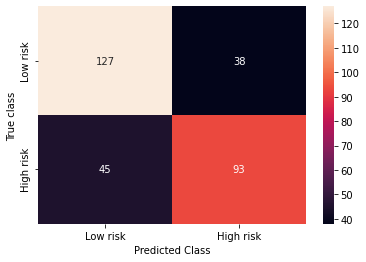

Depth of the tree: 6


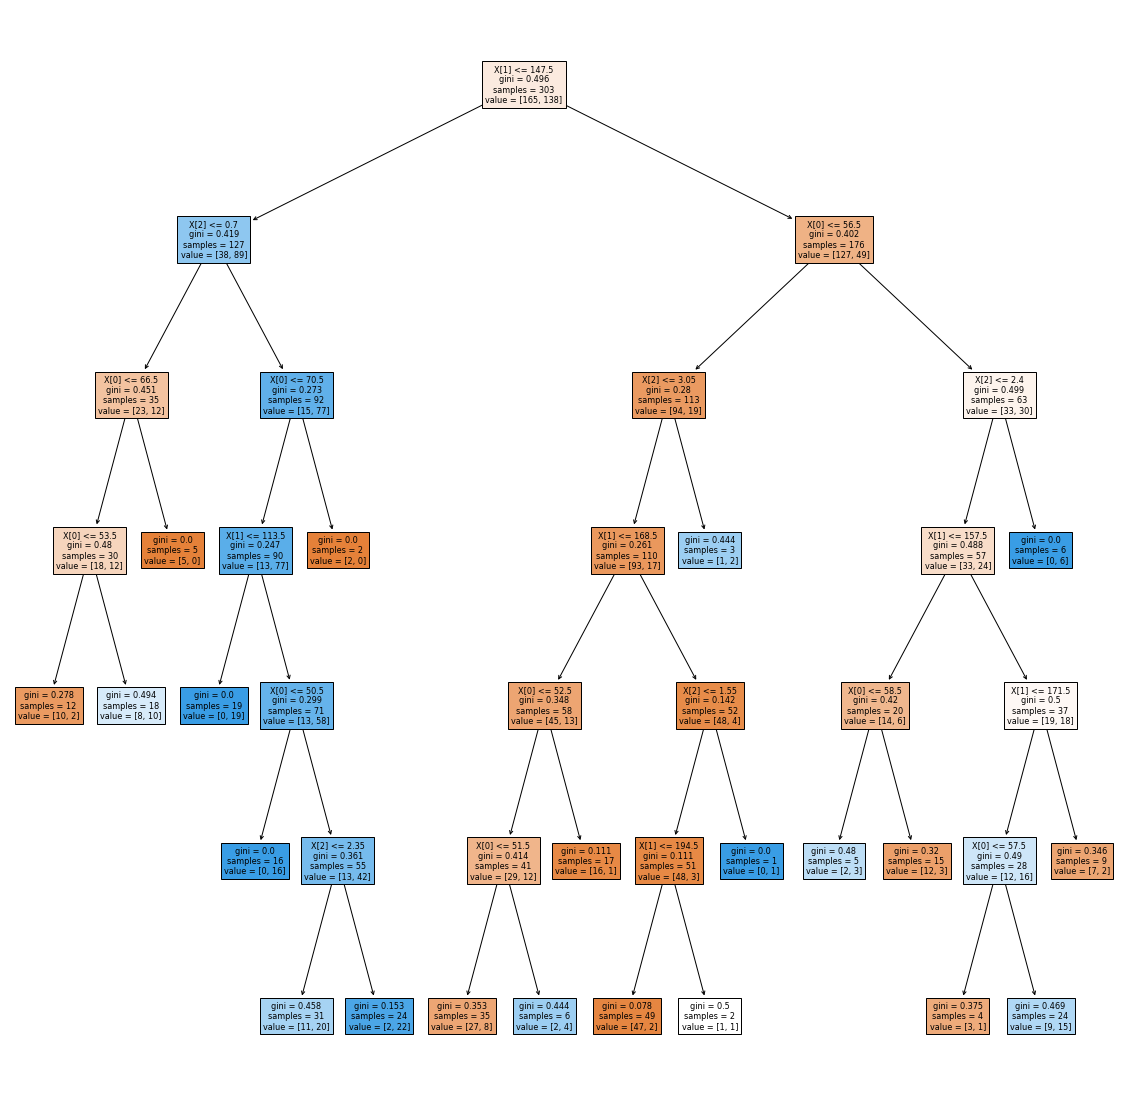

In [21]:
y_pred = cross_val_predict(model, X, y, cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1))
confusion = confusion_matrix(y, y_pred)
visualize_confusion_matrix(confusion)

from sklearn.tree import plot_tree
print("Depth of the tree:", model.get_depth())
plt.figure(figsize = (20,20))
plot_tree(model, filled = True)
plt.show()

## Binary/Categorical features

In [22]:
from sklearn.tree import DecisionTreeClassifier

# Define all possible sets of features
featureSets = [[1, 2, 4, 6, 7], [1, 2, 4, 6], [1, 2, 4, 7], [1, 2, 6, 7], [1, 4, 6, 7], [2, 4, 6 ,7]]

# Run through all sets of features
for features in featureSets:
    # Assemble the training set 
    X = modifiedDF.iloc[:, features].values
    y = pd.factorize(modifiedDF['output'].values)[0]
    # Training and training accuracy
    print("Features:", features, end = "\t")
    model = DecisionTreeClassifier(max_depth = 3, random_state = 1)
    model.fit(X, y)
    y_pred = model.predict(X)
    print("F-beta score:", fbeta_score(y, y_pred, beta = 1.2))

Features: [1, 2, 4, 6, 7]	F-beta score: 0.8176340383669454
Features: [1, 2, 4, 6]	F-beta score: 0.735955762221943
Features: [1, 2, 4, 7]	F-beta score: 0.8150799331901695
Features: [1, 2, 6, 7]	F-beta score: 0.8101907751750785
Features: [1, 4, 6, 7]	F-beta score: 0.8247153700189752
Features: [2, 4, 6, 7]	F-beta score: 0.8176340383669454


### Confusion matrix

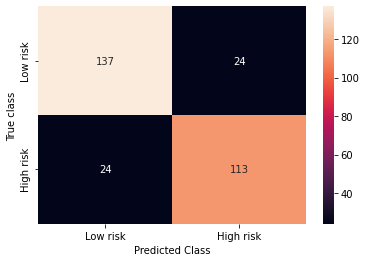

In [23]:
# Generate the training set
features = [1, 4, 6, 7]
X = modifiedDF.iloc[:,features].values
y = pd.factorize(modifiedDF['output'].values)[0]

# Train the model and predict the class for each training set
model = DecisionTreeClassifier(criterion = 'entropy', max_depth = 5, min_samples_split = 20, random_state = 1)
model.fit(X, y)
y_pred = model.predict(X)

# Calculate the confusion matrix
confusion = confusion_matrix(y, y_pred)

visualize_confusion_matrix(confusion)

### Learning curves

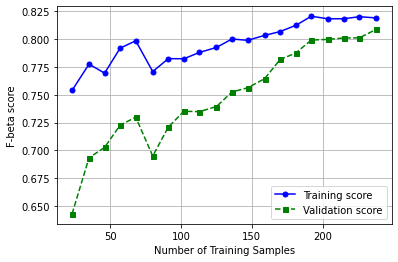

In [45]:
# Generate the training set
features = [1, 4, 6, 7]
X = modifiedDF.iloc[:,features].values
y = pd.factorize(modifiedDF['output'].values)[0]

# Create the model
model = DecisionTreeClassifier(criterion = 'entropy', max_depth = 5, min_samples_split = 20, random_state = 1)

plot_learning_curves(0.1, 50, 0.2)

### Validation curves

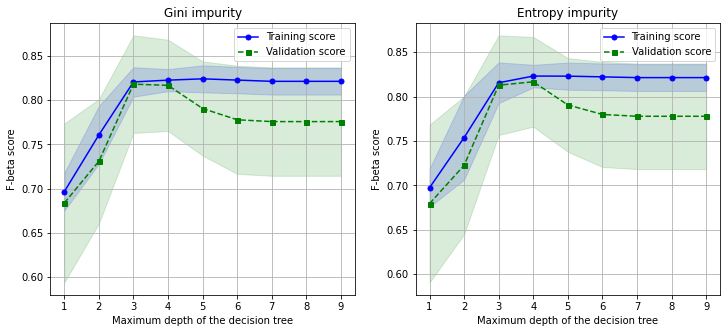

In [25]:
from sklearn.model_selection import validation_curve

# Generate the training set
features = [1, 4, 6, 7]
X = modifiedDF.iloc[:,features].values
y = pd.factorize(modifiedDF['output'].values)[0]

# Explore a range values for the maximum depth
param_range = range(1,10)

# Generate the validation curves for a model using the gini impurity measure
fig, ax = plt.subplots(1, 2, figsize = (12,5))
model = DecisionTreeClassifier(criterion = 'gini', random_state = 1)
generate_and_plot_validation_curves_decisiontree(model, ax[0])
ax[0].set_title('Gini impurity')

# Generate the validation curves for a model using the entropy impurity measure
model = DecisionTreeClassifier(criterion = 'entropy', random_state = 1)
generate_and_plot_validation_curves_decisiontree(model, ax[1])
ax[1].set_title('Entropy impurity')

plt.show()

### Best parameters

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Generate the training set
features = [1, 4, 6, 7]
X = modifiedDF.iloc[:,features].values
y = pd.factorize(modifiedDF['output'].values)[0]

# Create the model
model = DecisionTreeClassifier(random_state = 1)

# Set up the grid of parameters and the grid search
hyperParams = {'criterion': ['gini', 'entropy'],
               'max_depth': range(2, 6),
               'min_samples_split': [2, 10, 20, 30],
               'min_samples_leaf': [2, 10]}
search = GridSearchCV(model, hyperParams, cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1), scoring = heart_score)

# Generate random training and test sets
# Create the categories so that the conversion from a category to a number is always the same across different splits
heartCategories = pd.factorize(df['output'].values)[0]
X_train, X_test, y_train, y_test = train_test_split(df, heartCategories, test_size = 0.2, shuffle = True, stratify = df['output'])

# Train the model using the training set 
# search.fit(X_train.iloc[:,features], y_train)
search.fit(df.iloc[:,features], heartCategories)

# Look at scores
results = pd.DataFrame.from_dict(search.cv_results_)
print("Best score:", search.best_score_)
print("Best parameters:", search.best_params_)
results

Best score: 0.8231919452627169
Best parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 20}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.004872,0.002750,0.005804,0.005788,gini,2,2,2,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.720771,0.799266,0.655085,0.721419,0.692719,0.717852,0.047373,49
1,0.004867,0.002742,0.003969,0.001079,gini,2,2,10,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.720771,0.799266,0.655085,0.721419,0.692719,0.717852,0.047373,49
2,0.002449,0.000335,0.002426,0.000523,gini,2,2,20,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.720771,0.799266,0.655085,0.721419,0.692719,0.717852,0.047373,49
3,0.002374,0.000349,0.002274,0.000471,gini,2,2,30,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.720771,0.799266,0.655085,0.721419,0.692719,0.717852,0.047373,49
4,0.002429,0.000297,0.002170,0.000289,gini,2,10,2,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.720771,0.799266,0.655085,0.721419,0.692719,0.717852,0.047373,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,0.002987,0.000843,0.002238,0.000359,entropy,5,2,30,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.797386,0.809878,0.809409,0.839115,0.803091,0.811776,0.014416,15
60,0.003043,0.000935,0.002488,0.000608,entropy,5,10,2,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.774380,0.820775,0.798066,0.839115,0.803091,0.807085,0.021819,26
61,0.002929,0.001217,0.002810,0.000545,entropy,5,10,10,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.774380,0.820775,0.798066,0.839115,0.803091,0.807085,0.021819,26
62,0.002863,0.000668,0.003631,0.000808,entropy,5,10,20,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.774380,0.820775,0.798066,0.839115,0.803091,0.807085,0.021819,26


### Cross validation

In [44]:
# Generate the training set
features = [1, 4, 6, 7]
X = modifiedDF.iloc[:,features].values
y = pd.factorize(modifiedDF['output'].values)[0]

# Create the model
model = DecisionTreeClassifier(criterion = 'entropy', max_depth = 5, min_samples_split = 20)

model.fit(X, y)

# Stratified cross validation is used, cv specifies the number of folds
cv_scores = cross_val_score(model, X, y, cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1), scoring = heart_score)
print(cv_scores)
print(np.mean(cv_scores))
print(np.std(cv_scores))

[0.79080731 0.87997692 0.78444581 0.83800801 0.82737361]
0.8241223314956931
0.03466189693716352


### Cross validation classification

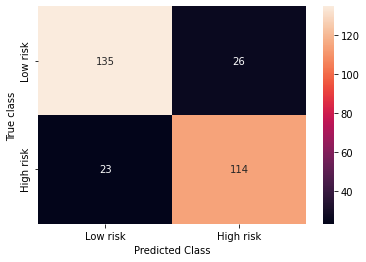

Depth of the tree: 5


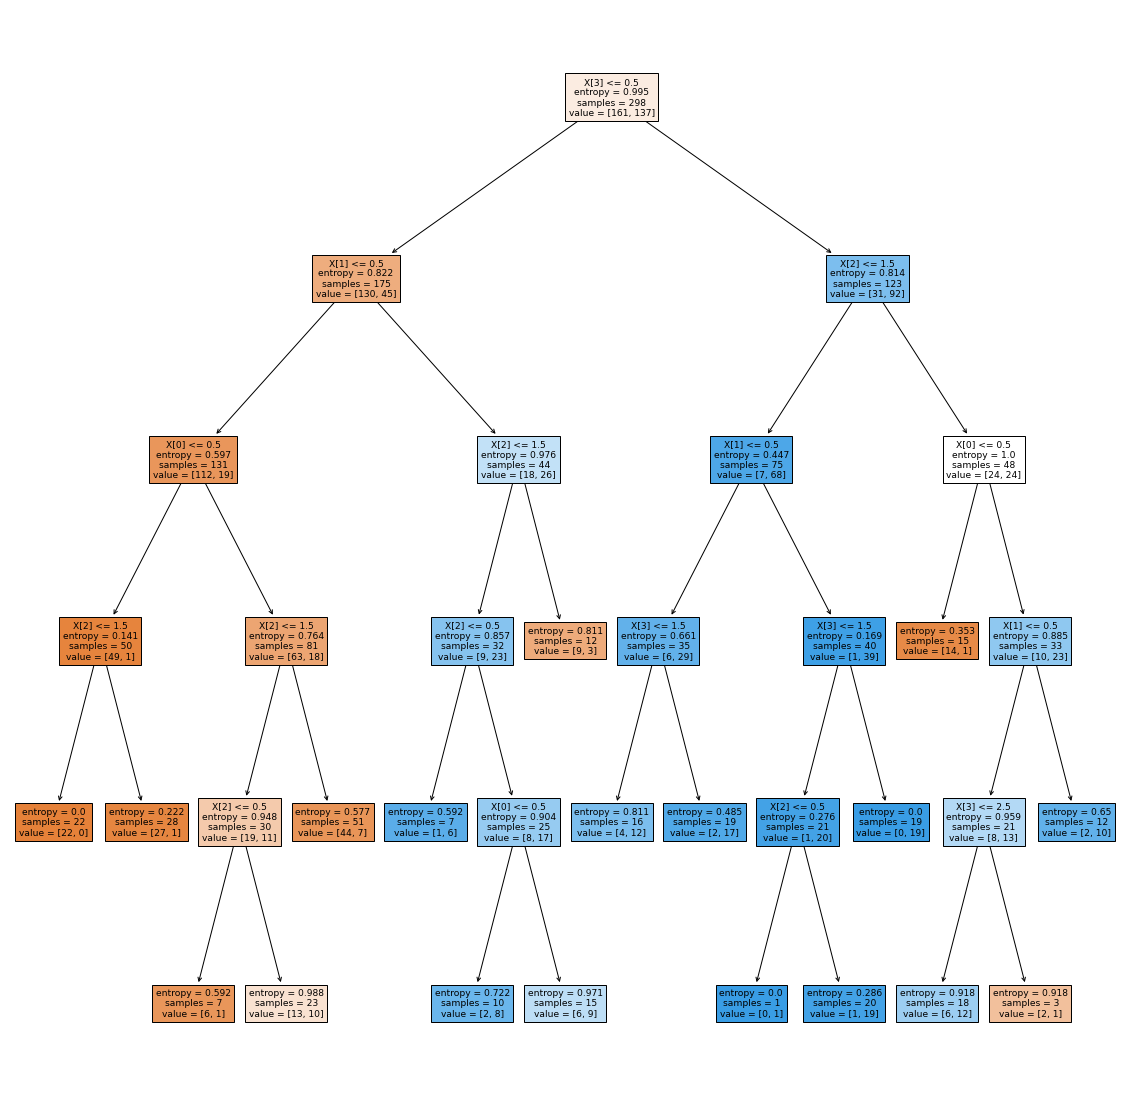

In [28]:
y_pred = cross_val_predict(model, X, y, cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1))
confusion = confusion_matrix(y, y_pred)
visualize_confusion_matrix(confusion)

from sklearn.tree import plot_tree
print("Depth of the tree:", model.get_depth())
plt.figure(figsize = (20,20))
plot_tree(model, filled = True)
plt.show()

# K Nearest Neighbors

In [29]:
# normalize all the features between 0 and 1
normalizedDF = (df - df.min()) / (df.max() - df.min())

## Continuous Features

In [30]:
from sklearn.neighbors import KNeighborsClassifier

# Define all possible sets of features
featureSets = [[0, 3, 5], [0, 3], [0, 5], [3, 5]]

# Run through all sets of features
for features in featureSets:
    # Assemble the training set 
    X = normalizedDF.iloc[:, features].values
    y = pd.factorize(normalizedDF['output'].values)[0]
    # Training and training accuracy
    print("Features:", features, end = "\t")
    model = KNeighborsClassifier()
    model.fit(X, y)
    y_pred = model.predict(X)
    print("F-beta score:", fbeta_score(y, y_pred, beta = 1.2))

Features: [0, 3, 5]	F-beta score: 0.757118520321246
Features: [0, 3]	F-beta score: 0.7326033203814906
Features: [0, 5]	F-beta score: 0.7107089737233515
Features: [3, 5]	F-beta score: 0.7402727386463156


### Confusion matrix

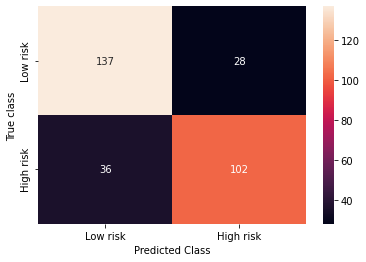

In [31]:
# Generate the training set
features = [0, 3, 5]
X = normalizedDF.iloc[:,features].values
y = pd.factorize(normalizedDF['output'].values)[0]

# Train the model and predict the class for each training set
model = KNeighborsClassifier(n_neighbors = 5, p = 2, weights = 'uniform')
model.fit(X, y)
y_pred = model.predict(X)

# Calculate the confusion matrix
confusion = confusion_matrix(y, y_pred)

visualize_confusion_matrix(confusion)

### Learning curves

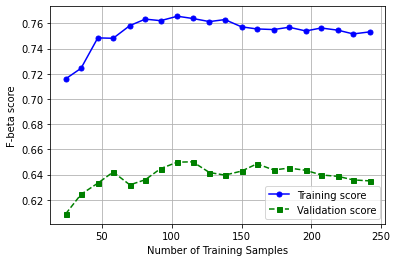

In [32]:
# Generate the training set
features = [0, 3, 5]
X = normalizedDF.iloc[:,features].values
y = pd.factorize(normalizedDF['output'].values)[0]

# Create the model
model = KNeighborsClassifier(n_neighbors = 5, p = 2, weights = 'uniform')

plot_learning_curves(0.1, 50, 0.2)

### Best parameters

In [33]:
# Generate the training set
features = [2, 4, 6, 7]
X = normalizedDF.iloc[:,features].values
y = pd.factorize(normalizedDF['output'].values)[0]

# Create the model
model = KNeighborsClassifier()

# Set up the grid of parameters and the grid search
hyperParams = {'n_neighbors': range(1, 9, 2),
               'weights': ['uniform', 'distance'],
               'p': [1, 2, 3, 4, 5, 10, 50]}
search = GridSearchCV(model, hyperParams, cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1), scoring = heart_score)

# Generate random training and test sets
# Create the categories so that the conversion from a category to a number is always the same across different splits
heartCategories = pd.factorize(normalizedDF['output'].values)[0]
X_train, X_test, y_train, y_test = train_test_split(df, heartCategories, test_size = 0.2, shuffle = True, stratify = normalizedDF['output'])

# Train the model using the training set 
# search.fit(X_train.iloc[:,features], y_train)
search.fit(normalizedDF.iloc[:,features], heartCategories)

# Look at scores
results = pd.DataFrame.from_dict(search.cv_results_)
print("Best score:", search.best_score_)
print("Best parameters:", search.best_params_)
results

Best score: 0.7756985738252968
Best parameters: {'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_p,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.007656,0.002156,0.023889,0.007819,1,1,uniform,"{'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}",0.595953,0.735826,0.716243,0.674499,0.676942,0.679893,0.048028,43
1,0.007048,0.003276,0.008590,0.002797,1,1,distance,"{'n_neighbors': 1, 'p': 1, 'weights': 'distance'}",0.595953,0.735826,0.716243,0.674499,0.676942,0.679893,0.048028,43
2,0.003672,0.001616,0.008724,0.002319,1,2,uniform,"{'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}",0.595953,0.735826,0.716243,0.674499,0.676942,0.679893,0.048028,43
3,0.004524,0.001576,0.005841,0.001191,1,2,distance,"{'n_neighbors': 1, 'p': 2, 'weights': 'distance'}",0.595953,0.735826,0.716243,0.674499,0.676942,0.679893,0.048028,43
4,0.003663,0.001360,0.007041,0.001296,1,3,uniform,"{'n_neighbors': 1, 'p': 3, 'weights': 'uniform'}",0.595953,0.735826,0.716243,0.674499,0.676942,0.679893,0.048028,43
5,0.002984,0.001018,0.004866,0.000932,1,3,distance,"{'n_neighbors': 1, 'p': 3, 'weights': 'distance'}",0.595953,0.735826,0.716243,0.674499,0.676942,0.679893,0.048028,43
6,0.003437,0.000987,0.006809,0.001123,1,4,uniform,"{'n_neighbors': 1, 'p': 4, 'weights': 'uniform'}",0.595953,0.735826,0.716243,0.674499,0.676942,0.679893,0.048028,43
7,0.002371,0.000530,0.003395,0.000453,1,4,distance,"{'n_neighbors': 1, 'p': 4, 'weights': 'distance'}",0.595953,0.735826,0.716243,0.674499,0.676942,0.679893,0.048028,43
8,0.001951,0.000024,0.005688,0.000455,1,5,uniform,"{'n_neighbors': 1, 'p': 5, 'weights': 'uniform'}",0.595953,0.735826,0.716243,0.674499,0.676942,0.679893,0.048028,43
9,0.004046,0.000756,0.005790,0.001529,1,5,distance,"{'n_neighbors': 1, 'p': 5, 'weights': 'distance'}",0.595953,0.735826,0.716243,0.674499,0.676942,0.679893,0.048028,43


### Cross validation

In [34]:
# Generate the training set
features = [0, 3, 5]
X = normalizedDF.iloc[:,features].values
y = pd.factorize(normalizedDF['output'].values)[0]

# Create the model
model = KNeighborsClassifier(n_neighbors = 5, p = 2, weights = 'uniform')

# Stratified cross validation is used, cv specifies the number of folds
cv_scores = cross_val_score(model, X, y, cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1), scoring = heart_score)
print(cv_scores)
print(np.mean(cv_scores))
print(np.std(cv_scores))

[0.66559692 0.77599558 0.63666014 0.7037037  0.49728261]
0.6558477900514278
0.09201283257095025


### Cross validation prediction

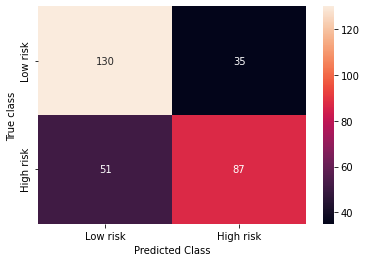

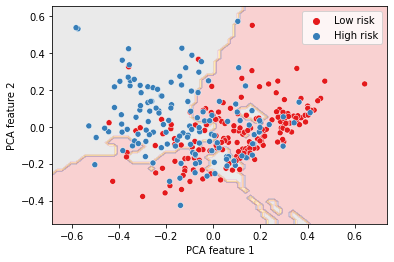

In [35]:
y_pred = cross_val_predict(model, X, y, cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1))
confusion = confusion_matrix(y, y_pred)
visualize_confusion_matrix(confusion)

model.fit(X, y)
show_classification_regions()

# Support Vector Machines

## Continuous features

In [36]:
from sklearn.svm import SVC

# Define all possible sets of features
featureSets = [[0, 3, 5], [0, 3], [0, 5], [3, 5]]

# Run through all sets of features
for features in featureSets:
    # Assemble the training set 
    X = normalizedDF.iloc[:, features].values
    y = pd.factorize(normalizedDF['output'].values)[0]
    # Training and training accuracy
    print("Features:", features, end = "\t")
    model = SVC()
    model.fit(X, y)
    y_pred = model.predict(X)
    print("F-beta score:", fbeta_score(y, y_pred, beta = 1.2))

Features: [0, 3, 5]	F-beta score: 0.6353307182469904
Features: [0, 3]	F-beta score: 0.6688767053423436
Features: [0, 5]	F-beta score: 0.6266297905966021
Features: [3, 5]	F-beta score: 0.6440422322775264


### Confusion matrix

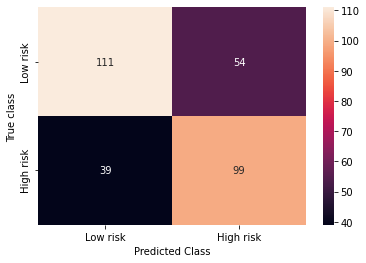

In [37]:
# Generate the training set
features = [0, 3, 5]
X = df.iloc[:,features].values
y = pd.factorize(df['output'].values)[0]

# Train the model and predict the class for each training set
model = SVC(C = .1, kernel = 'poly', degree = 5)
model.fit(X, y)
y_pred = model.predict(X)

# Calculate the confusion matrix
confusion = confusion_matrix(y, y_pred)

visualize_confusion_matrix(confusion)

### Learning curves

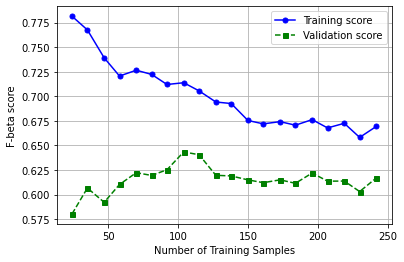

In [38]:
# Generate the training set
features = [0, 3, 5]
X = normalizedDF.iloc[:,features].values
y = pd.factorize(normalizedDF['output'].values)[0]

# Create the model
model = SVC(C = .1, kernel = 'poly', degree = 5)

plot_learning_curves(0.1, 50, 0.2)

### Best parameters

In [39]:
# Generate the training set
features = [0, 3, 5]
X = df.iloc[:,features].values
y = pd.factorize(df['output'].values)[0]

# Create the model
model = SVC()

# Set up the grid of parameters and the grid search
hyperParams = [{'C': [0.01, 0.1, 1.0], 'kernel': ['linear']},
               {'C': [0.01, 0.1, 1.0], 'kernel': ['poly'], 'degree': range(2, 12)},
               {'C': [0.01, 0.1, 1.0], 'kernel': ['rbf'], 'gamma': [0.01, 0.1, 1.0]}]
search = GridSearchCV(model, hyperParams, cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1), scoring = heart_score)

# Generate random training and test sets
# Create the categories so that the conversion from a category to a number is always the same across different splits
heartCategories = pd.factorize(df['output'].values)[0]
X_train, X_test, y_train, y_test = train_test_split(df, heartCategories, test_size = 0.2, shuffle = True, stratify = df['output'])

# Train the model using the training set 
# search.fit(X_train.iloc[:,features], y_train)
search.fit(df.iloc[:,features], heartCategories)

# Look at scores
results = pd.DataFrame.from_dict(search.cv_results_)
print("Best score:", search.best_score_)
print("Best parameters:", search.best_params_)
results

Best score: 0.7004355251101151
Best parameters: {'C': 0.1, 'degree': 5, 'kernel': 'poly'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,param_degree,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.007175,0.001800,0.004555,0.000481,0.01,linear,NaN,NaN,"{'C': 0.01, 'kernel': 'linear'}",0.716243,0.703982,0.699258,0.687539,0.561104,0.673625,0.057008,25
1,0.009906,0.001390,0.004640,0.002270,0.1,linear,NaN,NaN,"{'C': 0.1, 'kernel': 'linear'}",0.704750,0.728669,0.669410,0.709761,0.570474,0.676613,0.056423,22
2,0.029163,0.006406,0.003672,0.000743,1.0,linear,NaN,NaN,"{'C': 1.0, 'kernel': 'linear'}",0.704750,0.714286,0.669410,0.681340,0.561104,0.666178,0.054924,26
3,0.005555,0.001377,0.004880,0.001606,0.01,poly,2,NaN,"{'C': 0.01, 'degree': 2, 'kernel': 'poly'}",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,37
4,0.006617,0.001907,0.004080,0.001220,0.01,poly,3,NaN,"{'C': 0.01, 'degree': 3, 'kernel': 'poly'}",0.627572,0.635028,0.638521,0.630899,0.583732,0.623150,0.020053,33
5,0.009397,0.006622,0.004419,0.001834,0.01,poly,4,NaN,"{'C': 0.01, 'degree': 4, 'kernel': 'poly'}",0.699035,0.652406,0.704750,0.666667,0.593589,0.663289,0.039962,28
6,0.010340,0.001356,0.007829,0.003241,0.01,poly,5,NaN,"{'C': 0.01, 'degree': 5, 'kernel': 'poly'}",0.714286,0.659272,0.709737,0.666667,0.627504,0.675493,0.032624,23
7,0.005686,0.002260,0.003565,0.001306,0.01,poly,6,NaN,"{'C': 0.01, 'degree': 6, 'kernel': 'poly'}",0.684240,0.674779,0.703982,0.712855,0.627504,0.680672,0.029844,21
8,0.004442,0.000515,0.002639,0.000210,0.01,poly,7,NaN,"{'C': 0.01, 'degree': 7, 'kernel': 'poly'}",0.712693,0.698854,0.674779,0.712855,0.651709,0.690178,0.023721,15
9,0.005545,0.000860,0.003554,0.000501,0.01,poly,8,NaN,"{'C': 0.01, 'degree': 8, 'kernel': 'poly'}",0.689451,0.722282,0.689451,0.726584,0.651709,0.695895,0.027105,3


### Cross validation

In [40]:
# Generate the training set
features = [0, 3, 5]
X = normalizedDF.iloc[:,features].values
y = pd.factorize(normalizedDF['output'].values)[0]

# Create the model
model = SVC(C = .1, kernel = 'poly', degree = 5)

# Stratified cross validation is used, cv specifies the number of folds
cv_scores = cross_val_score(model, X, y, cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1), scoring = heart_score)
print(cv_scores)
print(np.mean(cv_scores))
print(np.std(cv_scores))

[0.71624266 0.72866894 0.67238212 0.78205128 0.61107837]
0.7020846755758343
0.057386790838395756


### Cross validation classification

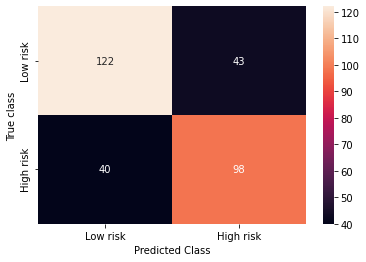

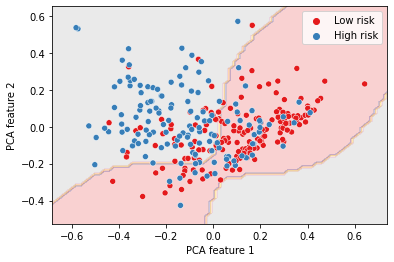

In [41]:
y_pred = cross_val_predict(model, X, y, cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1))
confusion = confusion_matrix(y, y_pred)
visualize_confusion_matrix(confusion)

model.fit(X, y)
show_classification_regions()

# Ensemble Learning

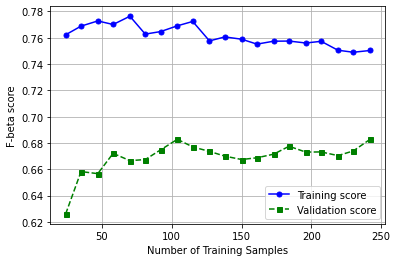

[0.66224367 0.70398153 0.65508528 0.72966507 0.58206107]
0.6666073247127511
0.05034477024289717


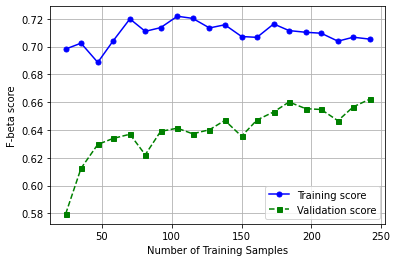

[0.64721485 0.72489602 0.66941015 0.71454994 0.57047428]
0.6653090488523101
0.055340986901232424


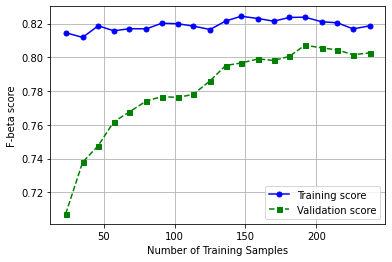

[0.87559809 0.89285714 0.6764514  0.83800801 0.78862314]
0.8143075573524998
0.0776560191922115


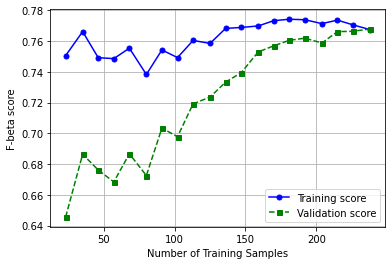

[0.74592391 0.82180037 0.63852059 0.82737361 0.72925457]
0.7525746100997264
0.06925817302046663


In [70]:
from sklearn.ensemble import VotingClassifier

# ensemble of 4 models using continuous features
X = df.iloc[:, [0, 3, 5]].values
y = pd.factorize(df['output'].values)[0]

model1 = GaussianNB()
model2 = DecisionTreeClassifier(criterion = 'entropy', max_depth = 6, min_samples_split = 20)
model3 = KNeighborsClassifier(n_neighbors = 5, p = 2, weights = 'uniform')
model4 = SVC(C = .1, kernel = 'poly', degree = 5, probability = True)
    
model = VotingClassifier(estimators=[('gnb', model1), ('dt', model2), ('knn', model3), ('sv', model4)], voting = 'soft')
model.fit(X, y)
plot_learning_curves(0.1, 50, 0.2)
cv_scores = cross_val_score(model, X, y, cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1), scoring = heart_score)
print(cv_scores)
print(np.mean(cv_scores))
print(np.std(cv_scores))

model = VotingClassifier(estimators=[('gnb', model1), ('dt', model2), ('knn', model3), ('sv', model4)], voting = 'hard')
model.fit(X, y)
plot_learning_curves(0.1, 50, 0.2)
cv_scores = cross_val_score(model, X, y, cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1), scoring = heart_score)
print(cv_scores)
print(np.mean(cv_scores))
print(np.std(cv_scores))

# ensemble of 2 models using binary/categorical features
X = modifiedDF.iloc[:, [1, 2, 4, 6, 7]].values
y = pd.factorize(modifiedDF['output'].values)[0]

model1 = GaussianNB()
model2 = DecisionTreeClassifier(criterion = 'entropy', max_depth = 5, min_samples_split = 20)

model = VotingClassifier(estimators=[('gnb', model1), ('dt', model2)], voting = 'soft')
model.fit(X, y)
plot_learning_curves(0.1, 50, 0.2)
cv_scores = cross_val_score(model, X, y, cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1), scoring = heart_score)
print(cv_scores)
print(np.mean(cv_scores))
print(np.std(cv_scores))

model = VotingClassifier(estimators=[('gnb', model1), ('dt', model2)], voting = 'hard')
model.fit(X, y)
plot_learning_curves(0.1, 50, 0.2)
cv_scores = cross_val_score(model, X, y, cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1), scoring = heart_score)
print(cv_scores)
print(np.mean(cv_scores))
print(np.std(cv_scores))